In [122]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from sympy import *
from math import factorial
import platform
import time

In [123]:
def extractStrokes(fileName: str):
    with open(fileName) as f:
        data = json.load(f)
    totalStrokes = len(data['strokes'])
    strokes = []
    for i in range(totalStrokes):
        if data['strokes'][i]['draw_type'] == 0:
            strokes.append(data['strokes'][i]['path'])
        else:
            continue
    #print("Total strokes: ", totalStrokes)
    return strokes

In [124]:
def comb(n, r):
    if r == 0:
        return 1
    else:
        return factorial(n) // (factorial(r) * factorial(n - r))

In [125]:
def extractCoeff(num):
    x = Symbol('x')
    b0, b1, b2, b3, b4, b5 = symbols('b0 b1 b2 b3 b4 b5')
    l = [b0, b1, b2, b3, b4, b5]
    m = 0
    for i in range(num):
        m += comb(num-1, i) * (x ** i) * ((1 - x) ** (num-1 - i)) * l[i] 
    coef = Poly(m, x).coeffs()
    coef.reverse()
    coef = [[coef[i].coeff(l[j]) for j in range(num)] for i in range(num)]
    return np.array(coef, dtype=np.float64)
    #return coef

In [126]:
def getControlPoints(points, order):
    #M = np.array(extractCoeff(6), dtype=np.float64)
    M = extractCoeff(order)
    P = points
    length = len(P)
    D = [0]
    for i in range(1, length):
        D.append(D[i-1] + np.linalg.norm(P[i] - P[i-1]))   
    #print(length, D)
    S = [D[i] / D[-1] for i in range(length)]
    S = np.array(S)
    '''if np.isnan(S).any():
        print(points)'''
    #print(S)
    T = np.tile(S, (order, 1)).transpose()
    T = np.power(T, np.arange(order))
    #print(M.shape, np.matmul(T.transpose(), T).shape)
    #print(T)
    C = np.matmul(np.matmul(np.matmul(np.linalg.inv(M), np.linalg.pinv(np.matmul(T.transpose(), T))), T.transpose()), P)
    #print(C)
    return C



In [127]:
def generatePath(points, order, T):
    M = extractCoeff(order)
    C = getControlPoints(points, order)
    #print(T.shape, M.shape, C.shape)
    path = np.matmul(np.matmul(T, M), C)
    return path

In [128]:
def getRange(ran, p):
    pmax = np.max(p, axis=0)
    pmin = np.min(p, axis=0)
    #print(pmax, pmin)
    if ran[0][0] > pmin[0]:
        ran[0][0] = pmin[0]
    if ran[0][1] > pmin[1]:
        ran[0][1] = pmin[1]
    if ran[1][0] < pmax[0]:
        ran[1][0] = pmax[0]
    if ran[1][1] < pmax[1]:
        ran[1][1] = pmax[1]
    return ran

In [129]:
def removeDuplicate(points):
    newPoints = []
    for i in range(len(points)):
        if i == 0:
            newPoints.append(points[i])
        else:
            if np.linalg.norm(points[i] - points[i-1]) > 0:
                newPoints.append(points[i])
    return np.array(newPoints)

In [130]:
def drawStrokes(strokes, t, file, imgFile):
    plt.figure(figsize=(10, 5))
    pic = plt.imread(imgFile)
    ax1 = plt.subplot(121)
    ax1.imshow(pic)
    ax2 = plt.subplot(122)
    #ran = [[100, 100], [0, 0]]
    for points in strokes:
        points = np.array(points)
        if np.unique(points, axis=0).shape[0] == 1:
            ax2.plot(points[:,0], points[:,1], 'bo', markersize=0.1)
            continue
        if len(points) <= 6:
            order = len(points) - 1
        else:
            order = 6
        T = np.tile(t, (order, 1)).transpose()
        T = np.power(T, np.arange(order))
        points = removeDuplicate(points)
        if len(points) > 20:
            for i in range(0, len(points), 19):
                p = points[i:i+20]
                if np.unique(p, axis=0).shape[0] == 1:
                    continue
                #ran = getRange(ran, p)
                #rang = getR(rang, p)
                path = generatePath(p, order, T)
                px, py = path[:,0], path[:,1]
                ax2.plot(px, py, 'b-')
        else:
            #ran = getRange(ran, points)
            #rang = getR(rang, points)
            path = generatePath(points, order, T)
            #x, y = points[:, 0], points[:, 1]
            px, py = path[:,0], path[:,1]
            ax2.plot(px, py, 'b-')
        #plt.plot(x, y, 'r.')
    ax2.axis('equal')
    ax2.invert_yaxis()
    savePath = 'curvefittingimg/'+ file[:-5] + '_generated.png'
    plt.savefig(savePath)
     
    #print('X: ', ran[0][0],'-',ran[1][0], '\nY: ', ran[0][1],'-',ran[1][1])


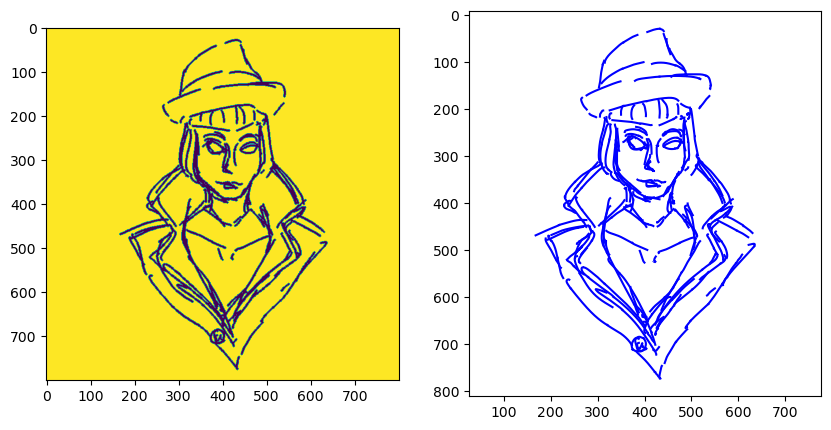

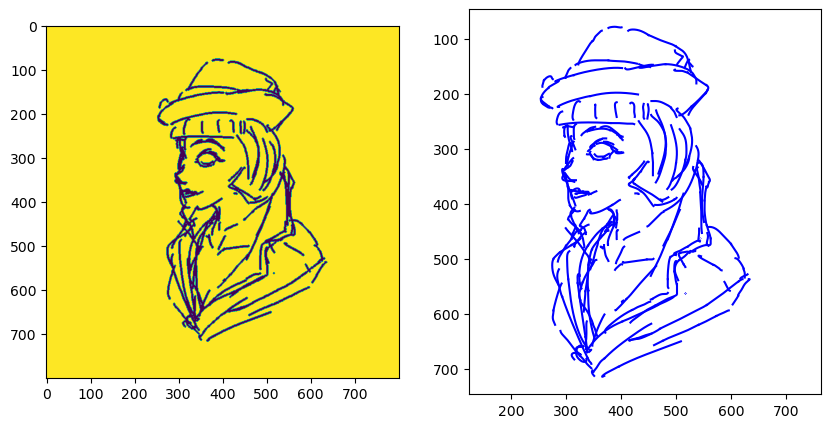

In [131]:
#points = np.array([[0, 0], [-1, 3], [4, 3], [6, 0], [7, 2.5]])
category = r'C:\Users\ssinc\Desktop\CityU\fyp\DifferSketching_Dataset\Human_Face'
dirPath = category + '\\' + 'original_json'
originalImage = category + '\\' + 'original_png'
dir_list = os.listdir(dirPath)
img_list = os.listdir(originalImage)
for i in range(2):
    #T1 = time.perf_counter()
    fileName = dirPath + '\\' + dir_list[i] 
    imgName = originalImage + '\\' + img_list[i]
    step = 0.001 #put the time step here
    
    strokes = extractStrokes(fileName)
    #print(strokes)
    #print(len(strokes))
    t = np.arange(0,1,step)
    #rang = [0, 0]
    
    drawStrokes(strokes, t, dir_list[i], imgName)
    
    #T2 = time.perf_counter()
    #print('running time:%ss' % ((T2 - T1)))
    
    #print('Range: ', rang[0], rang[1])
    